<a href="https://colab.research.google.com/github/bfatmab/Sale_Forcasting_With_AI/blob/main/Sale_Forcasting_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import os

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# Adım 1: Veri Setini Yükleme
data = pd.read_csv('amazon.csv')

<ipython-input-90-fc38145416dd>:13: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('amazon.csv')


# New Section

In [91]:
# İlk 10 veriyi getirir
data.head(10)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN
5,5,404-1490984-4578765,04-30-22,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,...,INR,824.00,GHAZIABAD,UTTAR PRADESH,201102.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
6,6,408-5748499-6859555,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,...,INR,653.00,CHANDIGARH,CHANDIGARH,160036.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
7,7,406-7807733-3785945,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,INR,399.00,HYDERABAD,TELANGANA,500032.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
8,8,407-5443024-5233168,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,SET200,SET200-KR-NP-A-XXXL,Set,...,NaN,NaN,HYDERABAD,TELANGANA,500008.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
9,9,402-4393761-0311520,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3461,JNE3461-KR-XXL,kurta,...,INR,363.00,Chennai,TAMIL NADU,600041.0,IN,NaN,False,NaN,NaN


In [92]:
# Satır ve sütun sayısnı verir
data.shape

(75117, 24)

Kolon çıkarma 

In [93]:
sale_channel='Sales Channel'
ship_service_level='ship-service-level'
courier_status='Courier Status'
un='Unnamed: 22'

columns=['index','Status','Fulfilment',ship_service_level,'Style','SKU','Size','ASIN',courier_status,'Qty','currency','ship-city','ship-state','ship-state','ship-postal-code','ship-country','promotion-ids','B2B','fulfilled-by',un]
data=data.drop(columns,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75117 entries, 0 to 75116
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        75117 non-null  object 
 1   Date            75117 non-null  object 
 2   Sales Channel   75116 non-null  object 
 3   Category        75116 non-null  object 
 4   Amount          70633 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


Date kolonunun tipini değiştirdik

In [94]:
data['Date'] = pd.to_datetime(data['Date'])

In [95]:
 
invalid_values = data['Amount'][~np.isfinite(data['Amount'])]

# NaN değerlere 0 atayın
data['Amount'] = data['Amount'].fillna(0)

In [96]:
data['Amount']=data['Amount'].astype('int64')

bir veri çerçevesindeki tarih sütununu aylık döneme çevirerek ve bu aylara göre satışları toplamlayarak aylık satışları hesaplar.

In [97]:
data['Date']= data['Date'].dt.to_period("D") 
dayly_sales=data.groupby('Date').sum().reset_index()

<ipython-input-97-37e8fdaf3b04>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dayly_sales=data.groupby('Date').sum().reset_index()


In [98]:
dayly_sales['Date']=dayly_sales['Date'].dt.to_timestamp()

In [99]:
dayly_sales.head(50)

,Date,Amount
0,2022-03-31,101680
1,2022-04-01,865448
2,2022-04-02,913076
3,2022-04-03,1011739
4,2022-04-04,882033
5,2022-04-05,950526
6,2022-04-06,886958
7,2022-04-07,909863
8,2022-04-08,1018586
9,2022-04-09,972038


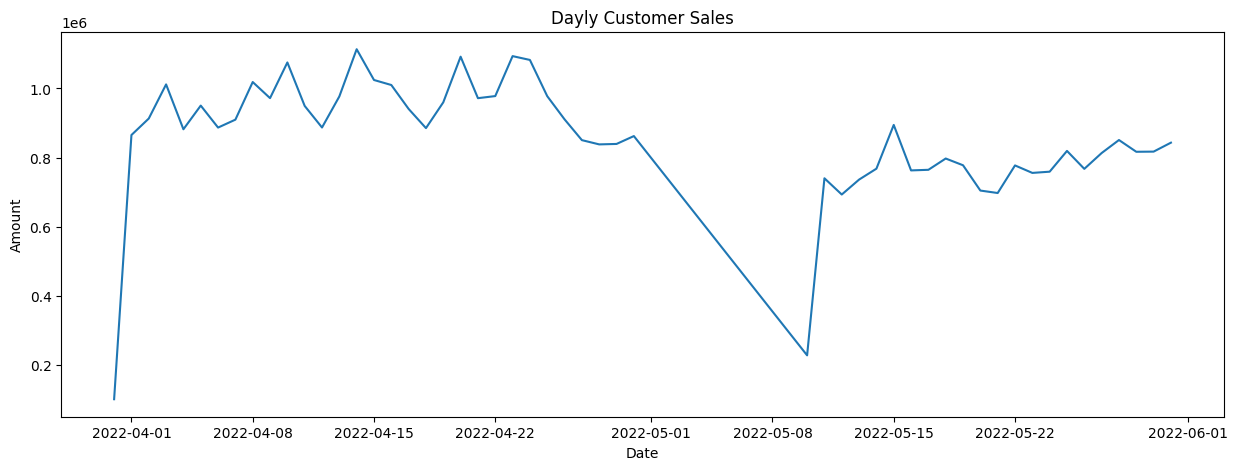

In [100]:
 plt.figure(figsize=(15,5))
 plt.plot(dayly_sales['Date'],dayly_sales['Amount'])
 plt.xlabel("Date")
 plt.ylabel("Amount")
 plt.title("Dayly Customer Sales")
 plt.show()

In [101]:
dayly_sales['sale_diff']=dayly_sales['Amount'].diff()
dayly_sales=dayly_sales.dropna()
dayly_sales.head(10)


,Date,Amount,sale_diff
1,2022-04-01,865448,763768.0
2,2022-04-02,913076,47628.0
3,2022-04-03,1011739,98663.0
4,2022-04-04,882033,-129706.0
5,2022-04-05,950526,68493.0
6,2022-04-06,886958,-63568.0
7,2022-04-07,909863,22905.0
8,2022-04-08,1018586,108723.0
9,2022-04-09,972038,-46548.0
10,2022-04-10,1075196,103158.0


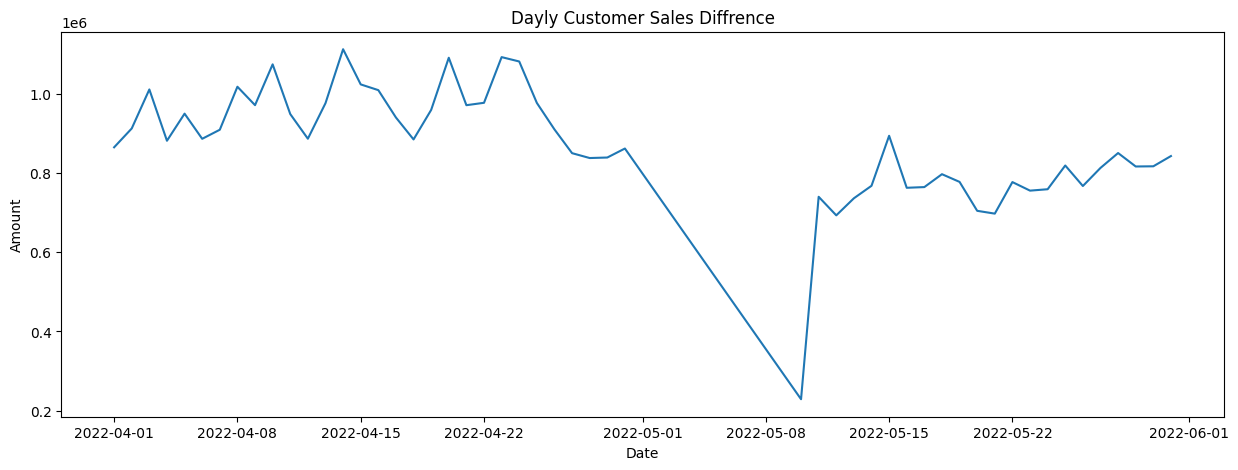

In [102]:
plt.figure(figsize=(15,5))
plt.plot(dayly_sales['Date'],dayly_sales['Amount'])
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title("Dayly Customer Sales Diffrence")
plt.show()


Sonuç olarak, "superised_date" veri çerçevesi, "dayly_sales" veri çerçevesinden "Date" ve "Amount" sütunlarını çıkararak oluşturulur. Bu yeni veri çerçevesi, sadece "Date" ve "Amount" sütunlarını içermeyen verileri içerir.

In [103]:
supervised_data=dayly_sales.drop(['Date','Amount'],axis=1)

In [104]:
for i in range(1, 32):
    col_name = 'day_' + str(i)
    supervised_data[col_name] = supervised_data['sale_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sale_diff,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,511840.0,-633863.0,22759.0,1299.0,-12304.0,-60072.0,-67013.0,-104728.0,-11056.0,115506.0,...,103158.0,-46548.0,108723.0,22905.0,-63568.0,68493.0,-129706.0,98663.0,47628.0,763768.0
1,-46943.0,511840.0,-633863.0,22759.0,1299.0,-12304.0,-60072.0,-67013.0,-104728.0,-11056.0,...,-125676.0,103158.0,-46548.0,108723.0,22905.0,-63568.0,68493.0,-129706.0,98663.0,47628.0
2,43150.0,-46943.0,511840.0,-633863.0,22759.0,1299.0,-12304.0,-60072.0,-67013.0,-104728.0,...,-62358.0,-125676.0,103158.0,-46548.0,108723.0,22905.0,-63568.0,68493.0,-129706.0,98663.0
3,31559.0,43150.0,-46943.0,511840.0,-633863.0,22759.0,1299.0,-12304.0,-60072.0,-67013.0,...,89817.0,-62358.0,-125676.0,103158.0,-46548.0,108723.0,22905.0,-63568.0,68493.0,-129706.0
4,126468.0,31559.0,43150.0,-46943.0,511840.0,-633863.0,22759.0,1299.0,-12304.0,-60072.0,...,136471.0,89817.0,-62358.0,-125676.0,103158.0,-46548.0,108723.0,22905.0,-63568.0,68493.0
5,-131486.0,126468.0,31559.0,43150.0,-46943.0,511840.0,-633863.0,22759.0,1299.0,-12304.0,...,-88948.0,136471.0,89817.0,-62358.0,-125676.0,103158.0,-46548.0,108723.0,22905.0,-63568.0
6,1766.0,-131486.0,126468.0,31559.0,43150.0,-46943.0,511840.0,-633863.0,22759.0,1299.0,...,-14506.0,-88948.0,136471.0,89817.0,-62358.0,-125676.0,103158.0,-46548.0,108723.0,22905.0
7,32614.0,1766.0,-131486.0,126468.0,31559.0,43150.0,-46943.0,511840.0,-633863.0,22759.0,...,-69190.0,-14506.0,-88948.0,136471.0,89817.0,-62358.0,-125676.0,103158.0,-46548.0,108723.0
8,-19500.0,32614.0,1766.0,-131486.0,126468.0,31559.0,43150.0,-46943.0,511840.0,-633863.0,...,-55440.0,-69190.0,-14506.0,-88948.0,136471.0,89817.0,-62358.0,-125676.0,103158.0,-46548.0
9,-73116.0,-19500.0,32614.0,1766.0,-131486.0,126468.0,31559.0,43150.0,-46943.0,511840.0,...,74651.0,-55440.0,-69190.0,-14506.0,-88948.0,136471.0,89817.0,-62358.0,-125676.0,103158.0


Split the data into Train and test

In [105]:
x=0.2 
n=len(supervised_data)
x_index=int(x*n)
train_data=supervised_data[:-x_index]
test_data=supervised_data[-x_index:]
print("Train Data Shape: ", train_data.shape)
print ("Test Data Shape: ", test_data.shape)


Train Data Shape:  (17, 32)
Test Data Shape:  (4, 32)


Min-Max Ölçeklendirme yöntemini kullanarak veri setinizi ölçeklendiriyor. Ölçeklendirme işlemi, veri değerlerini belirli bir aralığa dönüştürerek, farklı özelliklere sahip verilerin aynı ölçekte temsil edilmesini sağlar.

In [106]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Bu kod bloğu, eğitim ve test veri setlerini girdi (X) ve çıktı (y) olarak ayırarak, şekillerini ve boyutlarını kontrol etmeyi amaçlar.

Yani, [:, 1:] ifadesi veri setindeki tüm satırları ve 1'den sonraki sütunları seçerken, [:, 0:1] ifadesi tüm satırları ve sadece ilk sütunu seçer.

Örneğin, bir veri setiniz olduğunu düşünelim:

+-----+----+----+----+
| Col1|Col2|Col3|Col4|
+-----+----+----+----+
|  1  |  2 |  3 |  4 |
|  5  |  6 |  7 |  8 |
|  9  | 10 | 11 | 12 |
+-----+----+----+----+

[:, 1:] ifadesi kullanıldığında, aşağıdaki sonucu alırsınız:

+-----+----+----+
|Col2 |Col3|Col4|
+-----+----+----+
|  2  |  3 |  4 |
|  6  |  7 |  8 |
| 10  | 11 | 12 |
+-----+----+----+

Örneğin, yine aynı veri setini düşünelim:

+-----+----+----+----+
| Col1|Col2|Col3|Col4|
+-----+----+----+----+
|  1  |  2 |  3 |  4 |
|  5  |  6 |  7 |  8 |
|  9  | 10 | 11 | 12 |
+-----+----+----+----+

[:, 0:1] ifadesi kullanıldığında, aşağıdaki sonucu alırsınız:

+-----+
| Col1|
+-----+
|  1  |
|  5  |
|  9  |
+-----+


In [107]:
x_train ,y_train=train_data[:,1:],train_data[:,0:1]
x_test, y_test =test_data[:,1:], test_data[:,0:1]
y_train= y_train.ravel()
y_test=y_test.ravel()
print("X_train Shape:",x_train.shape)
print("y_train Shape:",y_train.shape)
print("x_test Shape:",x_test.shape)
print("y_test Shape:",y_test.shape)



X_train Shape: (17, 31)
y_train Shape: (17,)
x_test Shape: (4, 31)
y_test Shape: (4,)


In [108]:
sales_data=dayly_sales['Date'][-31:].reset_index(drop=True)
predizt_df=pd.DataFrame(sales_data)


In [109]:
act_sales=dayly_sales['Amount'][-32:].to_list()
print(act_sales)

[971927, 977997, 1093503, 1082447, 977719, 910706, 850634, 838330, 839629, 862388, 228525, 740365, 693422, 736572, 768131, 894599, 763113, 764879, 797493, 777993, 704877, 697762, 777531, 755904, 759446, 819456, 767607, 813322, 850974, 816980, 817448, 843338]


Lineer regrasyon oluşturuldu ve 

In [110]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre=lr_model.predict(x_test)

In [111]:
lr_pre =lr_pre.reshape(-1,1)
lr_pre_test_set =np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set =scaler.inverse_transform(lr_pre_test_set)
